# **Project: Document Scanning for Book Pages**

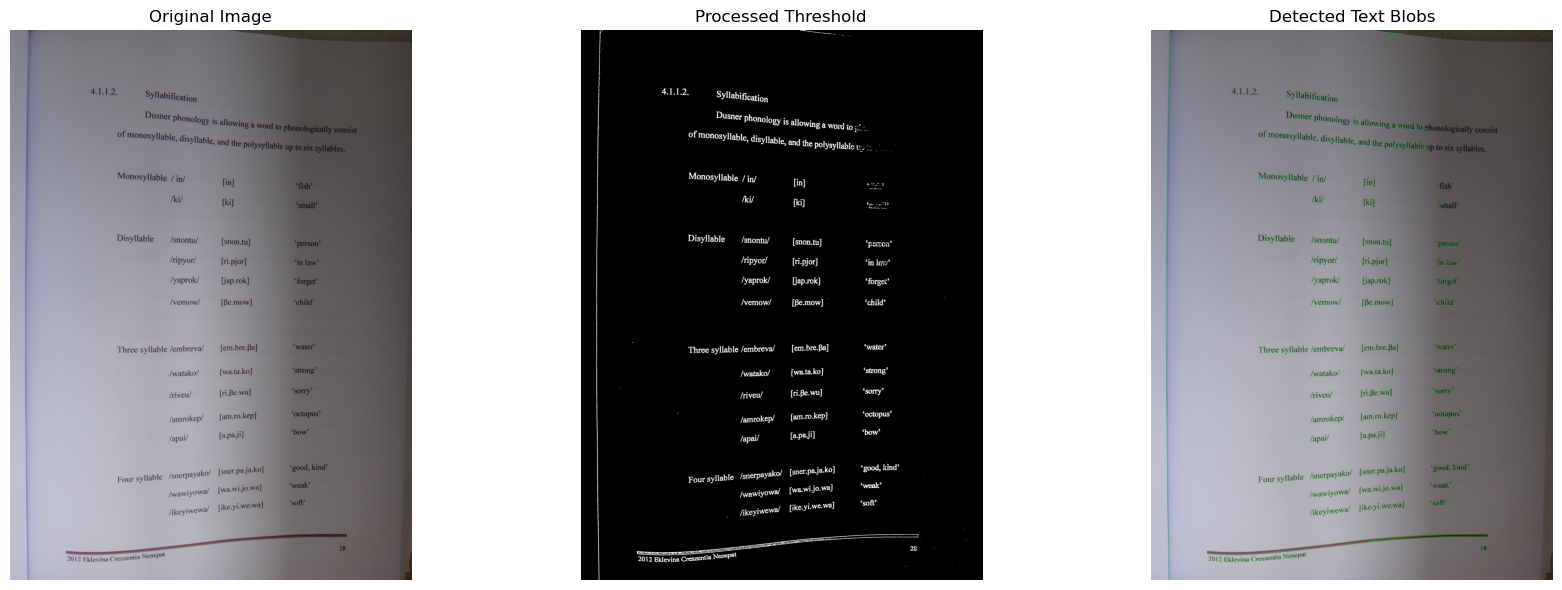

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_text_blobs(image_path):
    # Step 1: Load and Preprocess Image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Unable to load image.")
        return
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    height, width = gray.shape

    # Step 2: Crop the Image to Remove Borders
    margin = int(min(height, width) * 0.05)  # 5% margin
    cropped = gray[margin:height-margin, margin:width-margin]

    # Step 3: Normalize and Enhance Contrast
    normalized = cv2.normalize(cropped, None, 0, 255, cv2.NORM_MINMAX)
    equalized = cv2.equalizeHist(normalized)

    # Step 4: Gaussian Blur to Reduce Noise
    blurred = cv2.GaussianBlur(equalized, (5, 5), 0)

    # Step 5: Adaptive Thresholding
    thresh = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, blockSize=15, C=9
    )

    # Step 6: Morphological Operations
    # a. Closing to Connect Text Regions
    kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel_close, iterations=2)

    # b. Opening to Remove Small Noise
    kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel_open, iterations=1)

    # Step 7: Dilation to Enhance Text Blobs
    kernel_dilate = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    dilated = cv2.dilate(opened, kernel_dilate, iterations=1)

    # Step 8: Connected Component Analysis
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Step 9: Filter and Approximate Contours
    filtered_contours = []
    min_area = 100  # Minimum area threshold
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > min_area:
            filtered_contours.append(contour)

    # Step 10: Draw Contours on Original Image
    output_image = image[margin:height-margin, margin:width-margin].copy()
    cv2.drawContours(output_image, filtered_contours, -1, (0, 255, 0), 1)

    # Step 11: Visualize Results
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(image[margin:height-margin, margin:width-margin], cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Processed Threshold")
    plt.imshow(dilated, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Detected Text Blobs")
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    
    plt.tight_layout()
    plt.show()

# Example usage
detect_text_blobs("linguistics_thesis_a.jpg")
